 ![Logo Agro Toulouse](img/logo_ensat.jpg) ![Logo UT2J](img/UT2J_U_LOGO.png) ![Logo SIGMA](img/logo_sigma.png)

# **Projet télédétection avancée**

## UE 901-2 : Télédétection avancée
## UE 906 : Qualité et fouilles de données

Audrey Zimmer

Zone d'étude : Bretagne (2023 - 2024)

Objectif : Le but de cette étude est de caractériser la végétation en Bretagne et son évolution temporelle entre 2023 et 2024 à l'aide d'images Sentinel-2. Cette étude s'appuiera sur le calcul de l'ARI (Normalized Anthocyanin Reflectance Index)

Les Landes sont définies comme étant "un terrain ouvert où la végétation basse est dominée par des arbrisseaux à feuilles persistantes tels que la bruyère, l’ajonc ou le genêt." (Parc Naturel Régional Loire-Anjou-Touraine).

![Diagramme de flux](img/Projet_teledetection_diagramme.png) 
Figure 1 : Diagramme de flux détaillant les traitements réalisés au cours de cette étude.

# **Import des librairies**

In [1]:
# Librairies python
import sys
sys.path.append('..')
import os
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree
import geopandas as gpd
from osgeo import ogr
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Librairies personnelles
from libsigma import classification as cla
from libsigma import read_and_write as rw
from libsigma import plots


# **Création des dossiers**
Les dossiers results et figure, dans lesquels seront stockés les résultats, sont créés avec le bloc de code suivant.

In [2]:
# Chemin de base (absolu)
my_folder = "/home/onyxia/work/Projet_teledetection"


# Chemins des dossiers à créer (absolus)
results_path = os.path.join(my_folder, "../results")
figure_path = os.path.join(my_folder, "../results/figure")
img_path = os.path.join(my_folder, "img")


# Création des dossiers
os.makedirs(results_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)
os.makedirs(img_path, exist_ok=True) 

print("Dossiers results, figure et img créés avec succès !")


# Paramètres
dates = ['19-07-2024', '07-06-2024', '18-04-2024', '19-01-2024', '08-10-2023']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']


# Fichiers d'entrée 
path_b3 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif" 
path_b5 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif"
path_vecteur = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"


print("Configuration prête. Les sorties seront définies dans les blocs suivants.")


Dossiers results, figure et img créés avec succès !
Configuration prête. Les sorties seront définies dans les blocs suivants.


# **Formatage des données**
Le bloc de code suivant permet de vérifier le nombre de colonnes, de lignes et de bandes des images. Cela permet de savoir si les données peuvent être utilisées telles quelles ou s'il faut réaliser des transformations avant de commencer les traitements.

In [3]:
# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    
    # 1. Ouverture de l'image et stockage dans dataset 
    datasets[bande] = rw.open_image(chemin)
    
    print(f"Bande {bande}:")
    
    # 2. Obtention des informations de colonnes, de lignes et de bandes des données
    rw.get_image_dimension(datasets[bande], verbose=True)
    print("-" * 20) # Séparateur pour la lisibilité

Bande B02:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B03:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B04:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B05:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B06:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B07:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B08:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B8A:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B11:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B12:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Toutes les bandes obtenues ont la même dimension : 
- 1533 colonnes
- 612 lignes
- 5 bandes


Le bloc de code suivant permet de calculer l'emprise spatiale à partir des informations récupérées dans l'image bretagne_23-24_B03.tif.

In [4]:
# Calcul de l'emprise spatiale des données 

# 1. Ouvrir l'image de référence
ds = rw.open_image(path_b3)

# 2. Récupérer les dimensions (Lignes, Colonnes)
nb_lignes, nb_col, _ = rw.get_image_dimension(ds)

# 3. Récupérer l'origine (X_min, Y_max)
# Dans GDAL, l'origine est le coin SUPÉRIEUR gauche
origin_x, origin_y = rw.get_origin_coordinates(ds)

# 4. Récupérer la taille du pixel
# psize_y est généralement négatif car on descend dans l'image
psize_x, psize_y = rw.get_pixel_size(ds)

# 5. Calculer les bornes de l'emprise
x_min = origin_x
x_max = origin_x + (nb_col * psize_x)

y_max = origin_y
y_min = origin_y + (nb_lignes * psize_y) 

# Affichage des résultats
print("--- Emprise des données ---")
print(f"X Min (Ouest) : {x_min:.2f}")
print(f"X Max (Est)   : {x_max:.2f}")
print(f"Y Min (Sud)   : {y_min:.2f}")
print(f"Y Max (Nord)  : {y_max:.2f}")
print("-" * 27)

--- Emprise des données ---
X Min (Ouest) : 432950.00
X Max (Est)   : 448280.00
Y Min (Sud)   : 5362770.00
Y Max (Nord)  : 5368890.00
---------------------------


# **1. Analyse des échantillons**

![Diagramme de flux : Analyse des échantillons](img/Diagramme_Nb_echantillons.png) 
Figure 2 : Diagramme de flux détaillant l'analyse des échantillons

## **1.1. Nombre d'échantillons**

Le bloc de code suivant permet de calculer le nombre de polygones compris dans le fichier vecteur PI_strates_bretagne_32630.shp, comme montré sur le diagramme de flux ci-dessus. Le résultat obtenu est représenté sous le forme d'un histogramme qui sera enregistré dans le dossier results/figure sous le nom "diag_baton_nb_poly_by_class.png".

In [5]:
# --- ANALYSE DES ÉCHANTILLONS ---

# 1. Chargement du fichier
gdf = gpd.read_file(path_vecteur)

# 2. Préparation des données pour le diagramme
polygon_counts = gdf['strate'].value_counts().reset_index()
polygon_counts.columns = ['Classe', 'Nombre de polygones']
polygon_counts['Classe'] = polygon_counts['Classe'].astype(str)

# On s'assure d'avoir les 4 classes pour la cohérence visuelle
all_classes = pd.DataFrame({'Classe': ['1', '2', '3', '4']})
polygon_counts = all_classes.merge(polygon_counts, on='Classe', how='left').fillna(0)
polygon_counts['Nom'] = polygon_counts['Classe'].map({'1': 'Sol nu', '2': 'Herbe', '3': 'Landes', '4': 'Arbre'})

# 3. Création du diagramme de répartition
fig_polygons = px.bar(
    polygon_counts,
    x='Classe',
    y='Nombre de polygones',
    color='Classe',
    color_discrete_map={'1': '#d0d0d0', '2': '#b2df8a', '3': '#fdbf6f', '4': '#a47158'},
    title='Répartition des polygones d\'échantillonnage par classe',
    hover_data=['Nom'],
    category_orders={'Classe': ['1', '2', '3', '4']}
)

fig_polygons.update_xaxes(tickvals=['1', '2', '3', '4'], ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'])

# 4. Enregistrement
output_polygon_html = os.path.join(figure_path, 'diag_baton_nb_poly_by_class.html')
fig_polygons.write_html(output_polygon_html)
fig_polygons.show()

print(f"Analyse des échantillons terminée. Nombre total de polygones : {len(gdf)}")

Analyse des échantillons terminée. Nombre total de polygones : 278


Comme observé sur le graphique ci-dessus, la classe 1 (sol nu) est absente des échantillons. Les classes 2 (herbe) et 4 (arbre) présentent un nombre de polygones relativement proche, respectivement 86 et 71. La classe de landes (3) est celle qui contient le plus de polygones le plus élevé, avec 121 polygones.

## **1.2. Nombre de pixels par classe**

Le code suivant permet, dans un premier temps, de rasteriser le fichier vecteur PI_strates_bretagne_32630.shp avec la commande "cmd" selon les paramètres d'emprise déterminés précédemment et avec une résolution de 10m. Le fichier de sortie est enregistré dans le dossier results sous le nom "PI_strates_bretagne_32630_raster.tif".

Le deuxième bloc de code ci-dessous permet de calculer le nombre de pixels par strate dans le fichier d'échantillons rasterisé précédemment. Le résultat obtenu est enregistré dans le dossier results/figure sous le nom "diag_baton_nb_pix_by_class.png".

In [6]:
# --- Rasterisation ---

# 1. Définition du fichier de sortie (Ici et maintenant)
output_strates_raster = os.path.join(results_path, "PI_strates_bretagne_32630_raster.tif")

# 2. Paramètres de l'emprise (déjà calculés)
xmin, ymin, xmax, ymax = 432950.0, 5362770.0, 448280.0, 5368890.0 # Emprise du raster calculée précédemment
res = 10 # Résolution 10m

# 3. Commande de rasterisation
cmd = (f"gdal_rasterize -a strate -tr {res} {res} "
       f"-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
       f"{path_vecteur} {output_strates_raster}")

print(f"Création de : {output_strates_raster}")
os.system(cmd)

if os.path.exists(output_strates_raster):
    print("Le masque des strates est prêt.")

Création de : /home/onyxia/work/Projet_teledetection/../results/PI_strates_bretagne_32630_raster.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Le masque des strates est prêt.


In [7]:
# --- NOMBRE DE PIXELS PAR STRATE ---

# 1. Chargement du raster que tu viens de créer au Bloc 3
# On utilise ta fonction rw pour charger l'image en array
raster_array = rw.load_img_as_array(output_strates_raster)

# 2. Comptage des pixels par classe
unique, counts = np.unique(raster_array, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Exclure la classe 0 (fond/NoData)
pixel_counts.pop(0, None)

# 3. Création du DataFrame de synthèse
all_classes = pd.DataFrame({'Classe': [1, 2, 3, 4]})
pixel_df = pd.merge(
    all_classes,
    pd.DataFrame({'Classe': list(pixel_counts.keys()), 'Nombre de pixels': list(pixel_counts.values())}),
    on='Classe',
    how='left'
).fillna(0)

# 4. Configuration visuelle
color_map = {1: '#d0d0d0', 2: '#b2df8a', 3: '#fdbf6f', 4: '#a47158'}
noms_strates_complet = {1: 'Sol nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbre'}

# 5. Création du graphique unique et homogène
fig_pixels = go.Figure()

for classe in pixel_df['Classe']:
    count = pixel_df[pixel_df['Classe'] == classe]['Nombre de pixels'].values[0]
    fig_pixels.add_trace(go.Bar(
        x=[classe],
        y=[count],
        marker_color=color_map[classe],
        name=noms_strates_complet[classe],
        text=int(count), # Affiche le nombre au-dessus de la barre
        textposition='auto',
    ))

# Mise à jour du design
fig_pixels.update_layout(
    title='Distribution spatiale : Nombre de pixels par classe',
    xaxis_title='Type de strate',
    yaxis_title='Nombre de pixels',
    xaxis=dict(
        tickvals=[1, 2, 3, 4],
        ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'],
        type='category'
    ),
    template='plotly_white',
    showlegend=True
)

# 6. Enregistrement (Utilise le chemin figure_path défini au Bloc 1)
output_pixel_html = os.path.join(figure_path, 'diag_baton_nb_pix_by_class.html')
fig_pixels.write_html(output_pixel_html)

# Affichage
fig_pixels.show()

print(f"Statistiques de pixels sauvegardées dans : {output_pixel_html}")

Statistiques de pixels sauvegardées dans : /home/onyxia/work/Projet_teledetection/../results/figure/diag_baton_nb_pix_by_class.html


Le graphique ci-dessus représente le nombre de pixel pour chaque classe. Comme attendu, la classe de sol nu contient aucun pixel (il n'y a pas de polygones de sol nu). La classe d'herbe (strate 2) a le nombre de pixels le plus faible (1022), suivie de la classe d'arbre avec 1218 pixels. Enfin, la classe de landes (ou classe 3) contient 1599 pixels, soit la valeur la plus élevée pour les échantillons de Bretagne.

# **2. Phénologie des strates, mise en évidence des landes**

Les 2 blocs de code ci-dessous permettent de calculer l'ARI (Normalized Anthocyanin Reflectance Index) qui se définit par la formule suivante : 

![Formule de l'ARI](img/formule_ARI.png) 

Le résultat du calcul est enregistré dans le raster "ARI_serie_temp.tif". 

La moyenne et l'écart-type de ces données sont ensuite calculés et représentés sous la forme de séries temporelles, où chaque courbe correspond à la moyenne d'ARI pour chaque strate ± l'écart-type (représenté par l'enveloppe).

![Diagramme de flux - Calcul de l'ARI](img/Diagramme_ARI.png) 

Figure 3 : Diagramme de flux - Calcule de l'ARI

In [8]:
# --- Calcul ARI ---

# 1. Définition du fichier de sortie
output_ari_path = os.path.join(results_path, "ARI_serie_temp.tif")

# 2. Chargement des données via rw
print("Chargement des bandes...")
arr_b3 = rw.load_img_as_array(path_b3).astype(np.float32)
arr_b5 = rw.load_img_as_array(path_b5).astype(np.float32)

# 3. Calcul mathématique
with np.errstate(divide='ignore', invalid='ignore'):
    # Formule ARI : ((1/B03)-(1/B05)) / ((1/B03)+(1/B05))
    inv_b3 = 1.0 / arr_b3
    inv_b5 = 1.0 / arr_b5
    ari_stack = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

# Nettoyage NoData
ari_stack = np.nan_to_num(ari_stack, nan=-9999, posinf=-9999, neginf=-9999)

# 4. Écriture avec rw
ds_ref = rw.open_image(path_b3)
rw.write_image(output_ari_path, ari_stack, data_set=ds_ref, gdal_dtype=gdal.GDT_Float32)

print(f"ARI enregistré : {output_ari_path}")

Chargement des bandes...
ARI enregistré : /home/onyxia/work/Projet_teledetection/../results/ARI_serie_temp.tif


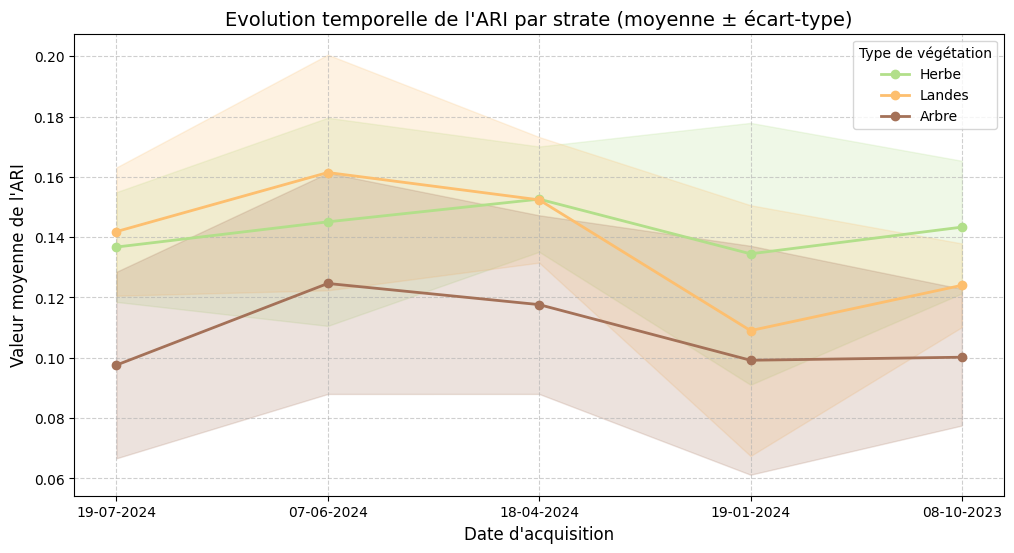

Graphique mis à jour sauvegardé : /home/onyxia/work/Projet_teledetection/../results/figure/ARI_series.png


In [ ]:
# --- Statistiques et Visualisation ---

# 1. Définition des dictionnaires de correspondance
noms_strates = {
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Ajout du dictionnaire de couleurs personnalisées
couleurs_strates = {
    2: "#b2df8a", 
    3: "#fdbf6f", 
    4: "#a47158" 
}

output_graphique = os.path.join(figure_path, "ARI_series.png")

# 2. Extraction des échantillons par strate
dict_X, Y, dict_t = cla.get_samples_from_roi(
    raster_name=output_ari_path,
    roi_name=output_strates_raster,
    output_fmt='by_label'
)

# 3. Création du graphique
plt.figure(figsize=(12, 6))
x_axis = np.arange(len(dates))

for label, pixels in dict_X.items():
    # Récupération du nom et de la couleur
    nom_label = noms_strates.get(label, f"Strate {label}")
    couleur = couleurs_strates.get(label, "black") # Noir par défaut si absent
    
    # Nettoyage NoData et calcul
    valid_pixels = np.where(pixels == -9999, np.nan, pixels)
    means = np.nanmean(valid_pixels, axis=0)
    stds = np.nanstd(valid_pixels, axis=0)
    
    # On applique 'color=couleur' aux deux fonctions
    plt.plot(x_axis, means, label=nom_label, marker='o', 
             linewidth=2, color=couleur)
    
    plt.fill_between(x_axis, means-stds, means+stds, 
                     alpha=0.2, color=couleur) # Alpha augmenté pour mieux voir

# Mise en forme finale
plt.xticks(x_axis, dates)
plt.title("Evolution temporelle de l'ARI par strate (moyenne ± écart-type)", 
          fontsize=14)
plt.xlabel("Date d'acquisition", fontsize=12)
plt.ylabel("Valeur moyenne de l'ARI", fontsize=12)
plt.legend(title="Type de végétation")
plt.grid(True, linestyle='--', alpha=0.6)

# Sauvegarde
plt.savefig(output_graphique, dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphique mis à jour sauvegardé : {output_graphique}")

La tendance générale des trois courbes est relativement similaire, avec une diminution entre octobre 2023 et janvier 2024, puis une augmentation jusqu'en avril ou juin 2024, suivie d'une diminution.
La classe des arbres présente la valeur moyenne d'ARI la plus faible entre le 08/10/2023 (à droite du graphique) et le 19/07/2024 (à gauche), son enveloppe (écart-type). Ses valeurs varient entre 0,10 et 0,12.
Entre octobre 2023 et avril 2024, c'est la moyenne d'ARI de l'herbe qui a les valeurs les plus élevées. Le 18/04/2024, sa valeur moyenne est la même que celle pour la strate de landes. Cette strate présente ensuite les valeurs maximales jusqu'à la fin des données étudiées ici.

# **3. Production d'une carte de strates à l'échelle du pixel**
## **Choix du classifieur et sa paramétrisation**

Les **hyperparamètres** et leurs valeurs testées pour cette classification sont les suivants : 

- **max_depth** [None, 10, 15, 20] : profondeur maximale des arbres. Une profondeur importante est nécessaire pour permettre au modèle de créer des règles de décision complexes, mais ces valeurs ne doivent pas être trop élevées afin d'éviter le sur-apprentissage.
- **max_features** [None, "sqrt", "log2"] : nombre de variables testées à chaque split. Ce paramètre permet de gérer la redondance des informations spectrales. Le limiter force à explorer les combinaisons de bandes moins dominantes.
- **min_samples_leaf** [1, 5] : nombre minimal d'échantillons dans une feuille. Les valeurs testées ont été fixées afin de réguler la finesse spatiale de la classification. Cela permet d'atténuer l'effet poivre et sel sur la carte finale, en s'assurant qu'une règle de décision repose sur un groupe de pixels cohérent. Les valeurs aberrantes sont éliminées.
- **n_estimators** [50, 100, 150, 200, 300] : nombre d'arbres de décision. Un nombre d'arbre élevé permet de stabiliser les prédictions face au bruit spectral et à la forte variabilité spectrale au sein d'une même strate, mais des valeurs trop élevées pourraient être coûteuses en temps de calcul.


--- Etape 2 : Création des groupes (ID polygones) ---
Champs trouvés dans le shapefile : ['id', 'strate', 'comment']
Utilisation du champ 'id' pour les groupes.
Nombre de groupes (polygones) détectés : 98
--- Etape 3 : Assemblage de 11 
   -> Chargement de : ARI_serie_temp.tif
   -> Chargement de : bretagne_23-24_B02.tif
   -> Chargement de : bretagne_23-24_B03.tif
   -> Chargement de : bretagne_23-24_B04.tif
   -> Chargement de : bretagne_23-24_B05.tif
   -> Chargement de : bretagne_23-24_B06.tif
   -> Chargement de : bretagne_23-24_B07.tif
   -> Chargement de : bretagne_23-24_B08.tif
   -> Chargement de : bretagne_23-24_B8A.tif
   -> Chargement de : bretagne_23-24_B11.tif
   -> Chargement de : bretagne_23-24_B12.tif
Extraction terminée : 3839 pixels prêts pour l'entraînement.
--- Etape 4 : Optimisation et Validation Croisée Groupée ---
Métrique utilisée pour l'optimisation : f1_macro
Meilleur score (f1_macro) obtenu : 0.9310
Meilleurs paramètres trouvés : {'max_depth': 15, 'max_featu

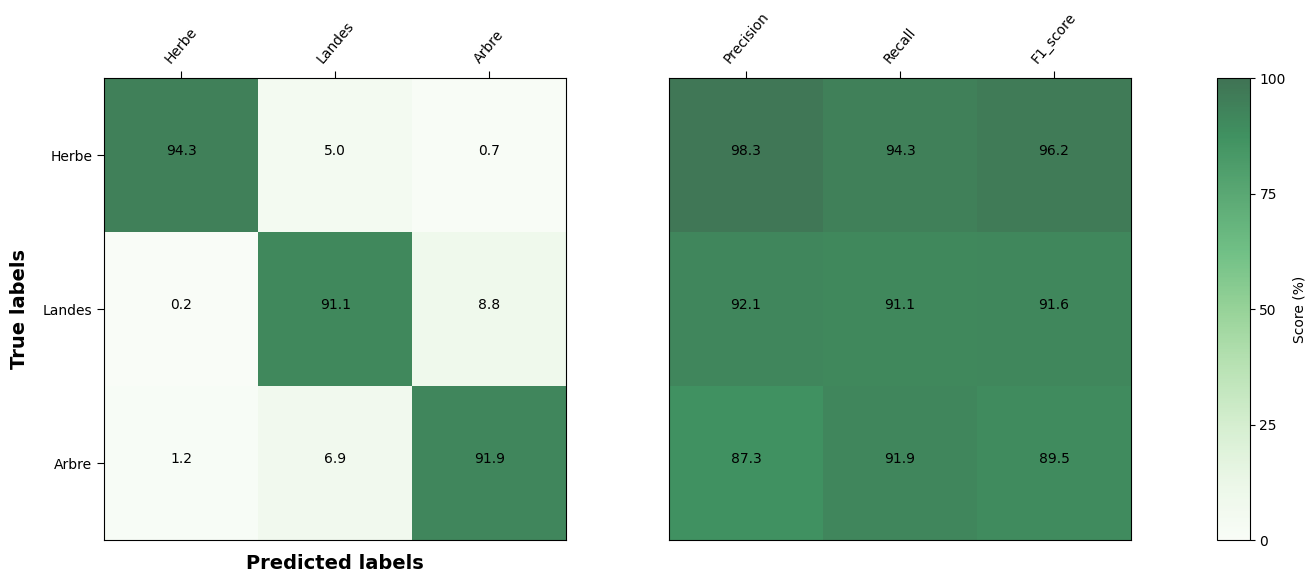

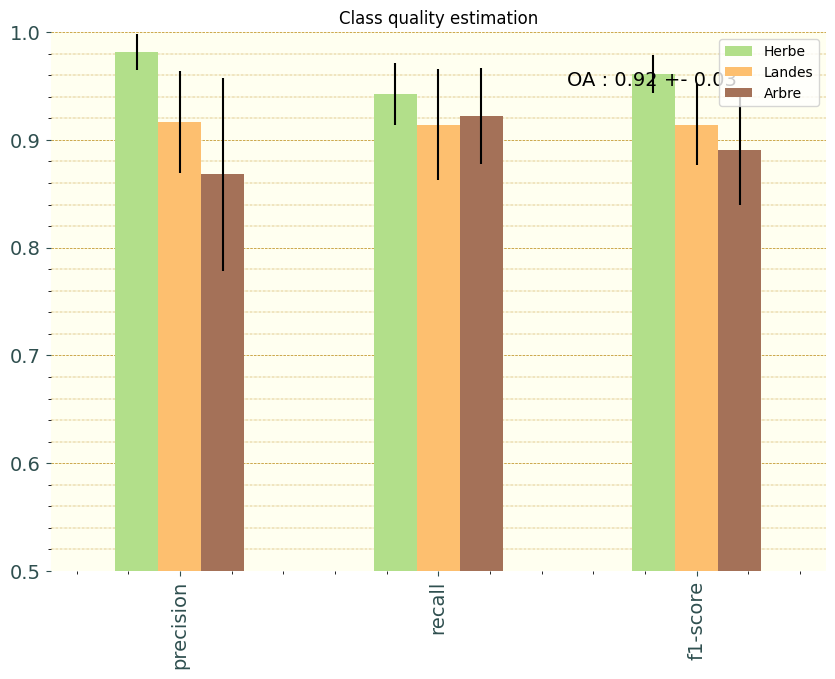

In [30]:
# -----------------
# 1. CONFIGURATION 
# -----------------
work_dir = '/home/onyxia/work'

# --- LISTE DES FICHIERS D'ENTRÉE que le modèle va utiliser
fichiers_entree = [
    os.path.join(work_dir, 'results/ARI_serie_temp.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B02.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B03.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B04.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B05.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B06.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B07.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B08.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B8A.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B11.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B12.tif'),
]

# Fichier d'échantillons rasterisé 
label_filename = os.path.join(work_dir, 'results/PI_strates_bretagne_32630_raster.tif')

# Fichier d'échantillons au format vecteur (pour créer les groupes de polygones)
shapefile_path = os.path.join(work_dir, 'data/projet_eval/PI_strates_bretagne_32630.shp')

output_dir = os.path.join(work_dir, 'results/figure')
os.makedirs(output_dir, exist_ok=True)

# Paramètres
NB_FOLDS = 5
NB_ITER = 10 
#CLASSES_LABELS = ['Sol nu', 'Herbe', 'Landes', 'Arbre']
#CLASSES_VALUES = [1, 2, 3, 4]

CLASSES_LABELS = ['Herbe', 'Landes', 'Arbre'] # les 3 strates pour la classification
CLASSES_VALUES = [2, 3, 4]

# ----------------------------
# 2. RASTÉRISATION DES GROUPES 
# ----------------------------
print("--- Etape 2 : Création des groupes (ID polygones) ---")
ref_ds = gdal.Open(fichiers_entree[0])
target_ds = gdal.GetDriverByName('MEM').Create(
    '', ref_ds.RasterXSize, ref_ds.RasterYSize, 1, gdal.GDT_UInt32
)
target_ds.SetGeoTransform(ref_ds.GetGeoTransform())
target_ds.SetProjection(ref_ds.GetProjection())

source_ds = ogr.Open(shapefile_path)
layer = source_ds.GetLayer()

# Chercher le champ ID 
defn = layer.GetLayerDefn()
field_names = [defn.GetFieldDefn(i).GetName() for i in range(defn.GetFieldCount())]
print(f"Champs trouvés dans le shapefile : {field_names}")

# On cherche un champ qui pourrait servir d'ID
# (utile pour pouvoir utiliser le script avec d'autres données)
id_field = None
for candidate in ['id', 'ID', 'OBJECTID', 'objectid', 'pk']:
    if candidate in field_names:
        id_field = candidate
        break

if id_field:
    print(f"Utilisation du champ '{id_field}' pour les groupes.")
    gdal.RasterizeLayer(target_ds, [1], layer, options=[f"ATTRIBUTE={id_field}"])
else:
    # Si aucun champ d'ID n'est trouvé, on utilise l'index interne du Shapefile
    print("Aucun champ ID trouvé, utilisation de l'index interne des entités")
    for feat in layer:
        # On brûle chaque polygone un par un avec son propre FID interne
        gdal.RasterizeLayer(target_ds, [1], layer, 
                           selection=f"FID={feat.GetFID()}", 
                           burn_values=[feat.GetFID()])
    layer.ResetReading()

groups_array = target_ds.GetRasterBand(1).ReadAsArray()

# VERIFICATION : Combien de groupes différents avons-nous ?
n_groups = len(np.unique(groups_array))
print(f"Nombre de groupes (polygones) détectés : {n_groups}")

# -------------------------
# 3. ASSEMBLAGE DES BANDES
# -------------------------
print(f"--- Etape 3 : Assemblage de {len(fichiers_entree)} ")

list_arrays = []
for f in fichiers_entree:
    print(f"   -> Chargement de : {os.path.basename(f)}")
    arr = rw.load_img_as_array(f)
    if len(arr.shape) == 2:
        arr = arr[:, :, np.newaxis]
    list_arrays.append(arr)

# Toutes les bandes sont collées ensembles
img_stack = np.concatenate(list_arrays, axis=2)
label_array = rw.load_img_as_array(label_filename)

# Mise à plat pour Scikit-Learn
n_rows, n_cols, n_bands = img_stack.shape
X_flat = img_stack.reshape(-1, n_bands)
y_flat = label_array.flatten()
groups_flat = groups_array.flatten()

# Masque : on ne garde que les pixels d'échantillonnage (y de 1 à 4)
mask = np.isin(y_flat, CLASSES_VALUES)
X_clean = X_flat[mask]
y_clean = y_flat[mask]
groups_clean = groups_flat[mask]

print(f"Extraction terminée : {X_clean.shape[0]} pixels prêts pour l'entraînement.")

# -------------------------------------
# 4. OPTIMISATION ET VALIDATION CROISÉE
# -------------------------------------

print("--- Etape 4 : Optimisation et Validation Croisée Groupée ---")

# Recherche des meilleurs hyperparamètres (GridSearchCV) 
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5]
}

cv_group = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=30)

grid = GridSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=30),
    param_grid, 
    cv=cv_group, 
    scoring='f1_macro'
)

grid.fit(X_clean, y_clean, groups=groups_clean)

# Afficher la métrique utilisée et le meilleur score obtenu
print(f"Métrique utilisée pour l'optimisation : {grid.scoring}")
print(f"Meilleur score ({grid.scoring}) obtenu : {grid.best_score_:.4f}")

best_params = grid.best_params_
print(f"Meilleurs paramètres trouvés : {best_params}")

# Évaluation statistique
list_cm, list_accuracy, list_report = [], [], []


print(f"Lancement de {NB_ITER} itérations d'évaluation...")

for i in range(NB_ITER):
    kf = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=i)
    train_idx, test_idx = next(kf.split(X_clean, y_clean, groups=groups_clean))
    
    clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=30)
    clf.fit(X_clean[train_idx], y_clean[train_idx])
    y_pred = clf.predict(X_clean[test_idx])
    
    # Stockage des résultats
    list_cm.append(confusion_matrix(y_clean[test_idx], y_pred, labels=CLASSES_VALUES))
    list_accuracy.append(accuracy_score(y_clean[test_idx], y_pred))
    
    report = classification_report(
        y_clean[test_idx], 
        y_pred, 
        labels=CLASSES_VALUES,
        target_names=CLASSES_LABELS, 
        output_dict=True,
        zero_division=0
    )
    
    # On transforme en DataFrame
    df_res = pd.DataFrame(report).transpose()
    
    # FILTRAGE POUR LE GRAPHIQUE :
    df_res_clean = df_res.loc[CLASSES_LABELS].drop(columns=['support'])
    
    list_report.append(df_res_clean)


print("Évaluation terminée avec succès.")


# Visualisation 
plots.plot_cm(np.array(list_cm).mean(axis=0), labels=CLASSES_LABELS, 
              out_filename=os.path.join(output_dir, 
              'matrice_confusion.png'), normalize=True)
#plots.plot_mean_class_quality(list_report, list_accuracy, 
                              #out_filename=os.path.join(output_dir, 
                              #'qualite_classes.png'))



# 1. Définition des couleurs (ordre : Herbe, Landes, Arbre)
couleurs_strates = ["#b2df8a", "#fdbf6f", "#a47158"]

# 2. Matplotlib utilisera ces couleurs 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=couleurs_strates)

# 3. Appel de la fonction faisant le graphique d'estimation de la qualité
plots.plot_mean_class_quality(
    list_report, 
    list_accuracy, 
    out_filename=os.path.join(output_dir, 'qualite_classes.png')
)

# 4. Remet les couleurs par défaut pour la suite du script
plt.rcdefaults()


# ------------------------------------------------------
# 5. PRODUCTION DE LA CARTE FINALE (AVEC MASQUE EXTERNE)
# ------------------------------------------------------
print("--- Etape 5 : Production de la carte finale ---")

# 1. Entraînement final
final_model = RandomForestClassifier(**best_params, n_jobs=-1)
final_model.fit(X_clean, y_clean)

# 2. Prédiction initiale
y_final_flat = final_model.predict(np.nan_to_num(X_flat))
classification_map = y_final_flat.reshape(n_rows, n_cols).astype(np.uint8)

# 3. GESTION DU NODATA VIA UNE COUCHE DE RÉFÉRENCE
# On charge une couche dont on est sûr du NoData (ici la bande B02)
ref_mask_path = os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B02.tif')
ds_mask = gdal.Open(ref_mask_path)
band_mask = ds_mask.GetRasterBand(1)
ref_data = band_mask.ReadAsArray()
nodata_value_ref = band_mask.GetNoDataValue()

# On définit le masque final : 
# Un pixel est NoData si :
# - Il a la valeur NoData officielle dans la couche de réf
# - OU il vaut 0 dans la couche de réf
# - OU il vaut NaN
mask_final_nodata = (ref_data == nodata_value_ref) | (ref_data == 0) | (np.isnan(ref_data))

# On applique ce masque sur notre classification
classification_map[mask_final_nodata] = 0

# 4. Sauvegarde 
output_tif = os.path.join(work_dir, 'results/carte_strates.tif')
rw.write_image(
    out_filename=output_tif,
    array=classification_map,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Byte
)

# Fixer le NoData officiel dans les métadonnées
out_ds = gdal.Open(output_tif, gdal.GA_Update)
out_ds.GetRasterBand(1).SetNoDataValue(0)
out_ds = None 

print(f"La carte finale est sauvegardée sous : {output_tif}")


### **Description des résultats de la classification supervisée**

La **matrice de confusion** permet de mettre en évidence les résultats de la classification. La plupart des pixels sont bien classés, valeurs en diagonale, qui fait correspondre les vraies valeurs aux valeurs prédites, avec des valeurs comprises entre 91.1% et 94.3%.

La **précision**, qui est la proportion de prédictions correctes parmi toutes les prédictions positives pour une classe, varie entre 87.3% (Arbre) et 98.3% (Herbe). Le **rappel** qui est la proportion de vrais positifs correctement identifiés par le modèle pour une classe, a des valeurs comprises entre 91.1% (Landes) et 94.3% (Herbe). Enfin, le **F1-score**, la moyenne harmonique entre précision et rappel, varie entre 89.5% (Arbre) et 96.2% (Herbe).

Le modèle a une **Overall Accuracy** (OA) de 92%, avec une faible incertitude de ±3% (deuxième figure). De plus, le graphique de **d'estimation de la qualité des classes"** observe des valeurs élevées. L'Herbe est la classe la mieux classifiée, suivie des Landes puis des Arbres. Les barres d'erreurs sont relativement petites sur la classe Herbe et plus importantes pour les deux autres strates.


---

## **2. Stratégie de validation**

La méthode de validation croisée utilisée ici est le **StratifiedGroupKFold** (validation croisée par groupes stratifiés), qui garanti à la fois que tous les échantillons appartenant au même groupe sont placés dans le même fold et que la proportion des classes est conservée dans chaque fold. Cela permet à la fois que la proportion des différentes classe est conservée, donc qu'elle est identique à celle du jeu de données initial et que le modèle ne soit pas surestimé en testant des pixels voisins de ceux appris.

Le jeu de données a été divisé en **5 sous-ensembles** (ou 5 folds). Dans ce cas, 80% des données sont utilisées pour l'entraînement et 20% pour le test, cela répliqué 5 fois. C'est un bon compromis entre la représentativité du jeu d'entraînement et la robustesse statistique. Prendre une valeur de K plus élevée aurait diminué le nombre de polygones pour chaque classe et inversement, avec une valeur plus faible il y a un risque de diversité d'échantillons insuffisants. Il y a donc un risque de sur-apprentissage si K est trop élevé ou de sous-apprentissage si K est trop faible. Ainsi, une valeur de 5 est un bon compromis.

La métrique utilisée afin de comparer les différentes est le **f1-score**. Pour rappel, le f1-score "peut être interprété comme une moyenne harmonique de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0. La contribution relative de la précision et du rappel au F1-score est égale." (scikit-learn). Cette métrique a été choisie ici afin d'accorder une importance égale à chaque strate, pour ne pas apporter un éventuel déséquilibre des classes.

Ici, c'est f1_macro qui a été choisi. Cette métrique est décrite de la manière suivante : "macro : "Calcule les métriques pour chaque étiquette et trouve leur moyenne non pondérée. Cela ne tient pas compte du déséquilibre des étiquettes." (scikit-learn.org). Les classes n'étant pas parfaitement équilibrées, cela permet que chaque classe soit traitée de la même manière. Ici, le f1-score obtenu est supérieur à 0.9.


--- 

## **3. Contribution des variables**

La partie suivante vise à analyser l'importance des variables sur le modèle de classification final entraîné avec les meilleurs hyperparamètres.

--- Etape 6 : Analyse de l'importance des variables ---

Classement complet de toutes les variables :
        Variable  Importance
B12 (19-07-2024)    0.065070
B05 (08-10-2023)    0.062915
B03 (19-07-2024)    0.058522
B04 (19-07-2024)    0.054003
B07 (07-06-2024)    0.051282
B07 (18-04-2024)    0.040858
B03 (08-10-2023)    0.040718
B8A (07-06-2024)    0.040103
B06 (07-06-2024)    0.040037
B11 (19-07-2024)    0.037632
B12 (08-10-2023)    0.037078
B08 (18-04-2024)    0.037066
B04 (18-04-2024)    0.036681
B08 (07-06-2024)    0.033696
B8A (18-04-2024)    0.028608
B05 (19-07-2024)    0.025528
B06 (19-07-2024)    0.023762
B06 (18-04-2024)    0.021338
B02 (08-10-2023)    0.019912
B12 (18-04-2024)    0.016860
B11 (08-10-2023)    0.016681
B11 (18-04-2024)    0.016176
B8A (19-07-2024)    0.016104
B07 (19-07-2024)    0.015641
B05 (18-04-2024)    0.014847
B02 (18-04-2024)    0.013509
B08 (19-07-2024)    0.013466
B02 (19-07-2024)    0.010412
B04 (08-10-2023)    0.009495
B05 (07-06-2024)    0.006407

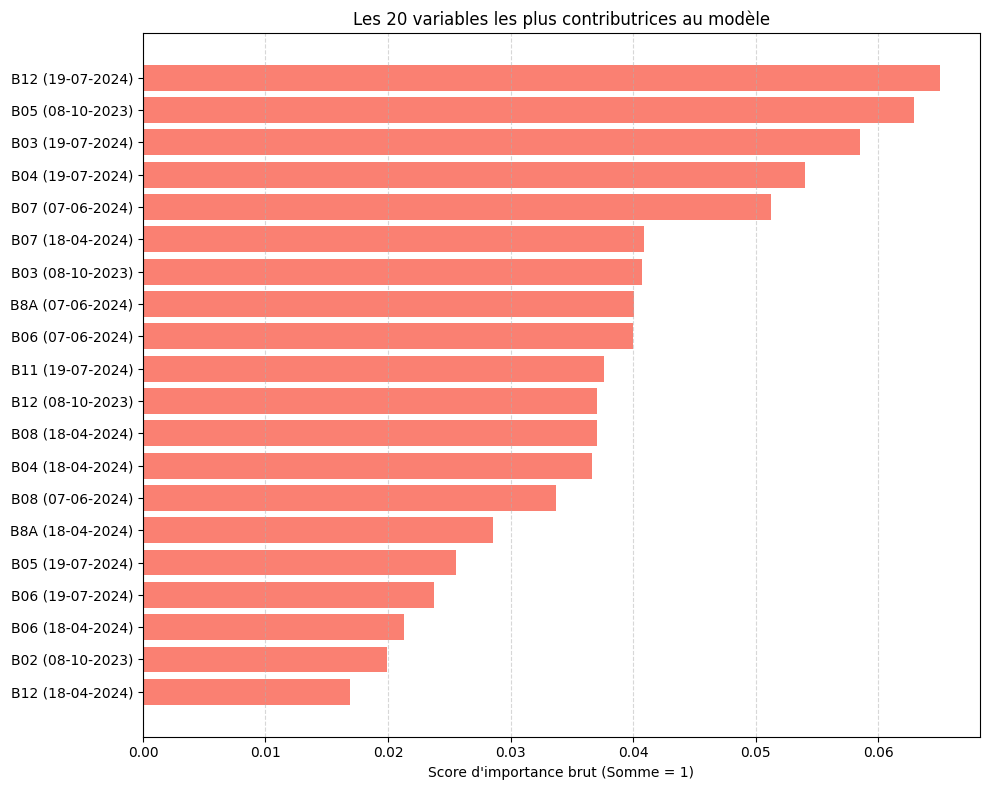

In [ ]:
# -----------------------------------------
# 6. ANALYSE DE L'IMPORTANCE DES VARIABLES
# -----------------------------------------
print("--- Etape 6 : Analyse de l'importance des variables ---")

importances = final_model.feature_importances_
noms_variables = []


for f in fichiers_entree:
    nom_fich = os.path.basename(f)
    
    # Extraction du nom court (B02, B03, ou ARI)
    if "ARI" in nom_fich:
        nom_clair = "ARI"
    else:
        # On prend ce qui est après le dernier '_' (ex: B12)
        nom_clair = nom_fich.split('_')[-1].replace('.tif', '')
    
    ds_temp = gdal.Open(f)
    nb_bandes = ds_temp.RasterCount
    
    if nb_bandes > 1:
        for b in range(1, nb_bandes + 1):
            # On récupère la date correspondante dans la liste 'dates'
            date_str = dates[b-1] if b <= len(dates) else f"b{b}"
            noms_variables.append(f"{nom_clair} ({date_str})")
    else:
        noms_variables.append(nom_clair)

# 2. Création du DataFrame COMPLET
df_importance_full = pd.DataFrame({'Variable': noms_variables, 
                        'Importance': importances})
df_importance_full = df_importance_full.sort_values(by='Importance', 
                        ascending=False)

# --- AFFICHAGE ---
print("\nClassement complet de toutes les variables :")
print(df_importance_full.to_string(index=False))

# 3. Préparation du Top 20 pour le graphique
df_plot = df_importance_full.head(20).sort_values(by='Importance', 
                        ascending=True)

# 4. Tracé du graphique
plt.figure(figsize=(10, 8))
plt.barh(df_plot['Variable'], df_plot['Importance'], color="salmon")

plt.xlabel('Score d\'importance brut (Somme = 1)')
plt.title('Les 20 variables les plus contributrices au modèle')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Sauvegarde
output_plot = os.path.join(output_dir, 'importance_variables.png')
plt.savefig(output_plot)
plt.show()

Ce graphique représente l'importance des variables au modèle. Cela permet de comparer l'importance de chaque bande. Les fichiers sont notés de la manière suivante : bretagne_23-24_bande_date". L'importance varie entre 0.001816 et 0.062967 et la somme totale est égale à 1.

Les bandes 12 et 11 (infrarouge) sont largement représentées sur ce graphique, indiquant une forte contribution. De plus, les bandes du proche-infrarouge (B06, B07, B08 et B8A) sont également très présentes.

A l'inverse, l'ARI contribue très peu au modèle, avec 3 dates sur les 5 qui sont les variables contribuant le moins.

Le graphique suivant rappelle les bandes spectrales de Sentinel-2 : 

![Bandes spectrales Sentinel-2 (CESBIO)](img/bandes_spectrales.png) 

Figure ?? : Bandes spectrales Sentinel-2 (CESBIO)

---

## 4. Production de la carte finale

La carte suivante représente une partie de la zone d'étude qui a été classifiée, superposée avec les échantillons qui ont servi à la classification. La zone présente une validation cohérente, en comparant les données classifiées avec les échantillons.

![Logo UT2J](img/carte_classification.png) 

Figure ?? : Carte des strates

Une partie des strates semble ne pas être bien classifiée, comme observé sur la carte suivante. En effet, la strate "arbre" est présente alors que les échantillons les plus proches sont ceux d'herbe et de lande.

---

## 5. Analyse des résultats


### 1. Qualité du modèles et des classes

Le modèle atteint une Overall Accuracy (OA) de 92%, ce qui indique une excellente capacité à classer correctement les pixels dans les trois strates étudiées (Herbe, Landes et Arbre) et l'incertitude de ±3% suggère une stabilité robuste des performances, avec une faible sensibilité de variation aux échantillons.
Interprétation :

Les métriques par classe (précision, rappel, F1-score) montrent des performances inégales entre les strates, comme observé sur la matrice de confusion. L'Herbe est la classe la mieux prédite, avec un F1-score de 96.3%. Cela suggère que cette strate se distingue particulièrement des autres, soit au niveau spectral, soit avec des échantillons très représentatifs.

Les Landes ont des performances proches de l'Herbe, mais avec des valeurs de métriques inférieures. La confusion qui est faite entre les Landes et les Arbres peut expliquer ce résultat. Enfin, les Arbres ont la Précision la plus faible (87.3%), ce qui indique que 12,7% des pixels classés comme Arbre appartiennent en réalité à une autre classe. Cela peut indiquer une ressemblance spectrale entre deux strates, notamment entre les Landes et les Arbres.

La matrice de confusion met en valeur les erreurs de classification du modèle. La confusion la plus importante est entre les Landes et les Arbres. En effet, 8.8% des Landes sont classées comme Arbre et 6.9% des Arbres sont classés comme Landes. Cela peut s'expliquer par des caractéristiques spectrales proches ou similaires. L'ARI, qui est un indice permettant de distinguer les Landes, a une importance très faible dans le modèle de classification. De plus, 5.0% des Herbes sont classées comme des Landes. Cela peut s'expliquer par une ressemblance entre les Landes et l'Herbe.

---

### 2. Pistes d'amélioration du modèle

#### a. Absence de sol nu dans les échantillons

La classe "sol nu" (strate 1) ne contient aucun polygone, comme montré dans le premier histogramme. Le modèle de classification n'a donc pas appris à reconnaître cette strate. Cela peut donc être problématique dans le cas de la présence de cette strate en conditions réelles. Il serait donc intéressant de vérifier que l'absence de cette strate correspond bien à la réalité.

#### b. Nombre de polygones utilisé limité

Le nombre total de polygones s'élève à 278, or, pendant la classification, seuls 98 polygones sont utilisés. Il peut s'agir d'un problème de géométrie mais il serait intéressant de comprendre pourquoi le modèle n'utilise pas tous les polygones à sa disposition.

#### c. Utilisation d'autres indices de végétation
Dans cette étude, seul l'indice ARI est utilisé. Cependant, il s'agit de la variable qui contribue le moins au modèle. Le calcul et l'intégration d'autres indices de végétation (comme le NDVI) dans le modèle pourrait permettre de l'améliorer, notamment à mieux distinguer les Arbres des Landes.




L'ARI est un indicateur proposé par Gitelson et al (2001). Il s'agit de "l'indice de réflectance des anthocyanes (ARI) basé sur les réponses spectrales vertes et rouges des feuilles (Bayle et al., 2019).

Il serait intéressant de calculer d'autres indices en lien avec la végétation, comme le NDVI, et de réaliser une classification en les intégrant afin d'analyser de possibles différences. De plus, il serait intéressant de regarder l'ajustement du modèle pour voir si over-fitting ou sous-apprentissage.

# Bibliographie

Bayle, A., Carlson, B. Z., Thierion, V., Isenmann, M., & Choler, P. 2019. Improved Mapping of Mountain Shrublands Using the Sentinel-2 Red-Edge Band. Remote Sensing, 11(23), 2807. https://doi.org/10.3390/rs11232807 

CESBIO : Séries temporelles optiques (Venus, Sentinel-2, Landsat). https://www.cesbio.cnrs.fr/la-recherche/activites/missions-spatiales/sentinel-2/

Gitelson, A.A., Merzlyak, M.N. 1996. Signature Analysis of Leaf Reflectance Spectra: Algorithm Development for Remote Sensing of Chlorophyll, Journal of Plant Physiology, Volume 148, Issues 3–4, Pages 494-500, ISSN 0176-1617, https://doi.org/10.1016/S0176-1617(96)80284-7.

Parc Naturel Regional Loire-Anjou-Touraine. Les Landes. https://www.parc-loire-anjou-touraine.fr/sites/default/files/2020-04/fiche-landes.pdf

scikit-learn - f1_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
